In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import datetime
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sample_data
from statsmodels.tsa.api import VAR 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
data = pd.read_csv('./inflation.csv')

In [4]:
df_usa = data[data['country'] == 'United States']

In [5]:
df_usa.head()

,country,year,"Inflation, consumer prices (annual %)","Inflation, GDP deflator (annual %)",Real interest rate (%),Deposit interest rate (%),Lending interest rate (%),"Unemployment, total (% of total labor force) (national estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",iso3c,iso2c,adminregion,incomeLevel
13156,United States,1970,5.838255,5.602170,2.185400,NaN,7.910000,4.9,NaN,USA,US,NaN,High income
13157,United States,1971,4.292767,5.069167,0.622605,NaN,5.723333,5.9,NaN,USA,US,NaN,High income
13158,United States,1972,3.272278,4.322751,0.887229,NaN,5.248333,5.6,NaN,USA,US,NaN,High income
13159,United States,1973,6.177760,5.479881,2.409735,NaN,8.021667,4.9,NaN,USA,US,NaN,High income
13160,United States,1974,11.054805,8.998695,1.651064,NaN,10.798333,5.6,NaN,USA,US,NaN,High income


In [6]:
columns = df_usa.columns
columns

Index(['country', 'year', 'Inflation, consumer prices (annual %)',
       'Inflation, GDP deflator (annual %)', 'Real interest rate (%)',
       'Deposit interest rate (%)', 'Lending interest rate (%)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'iso3c', 'iso2c', 'adminregion', 'incomeLevel'],
      dtype='object')

In [7]:
columns_to_delete = ['Deposit interest rate (%)',
                    'country',
                    'Inflation, GDP deflator (annual %)',
                    'Lending interest rate (%)',
                    'Unemployment, total (% of total labor force) (national estimate)',
                    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
                    'iso3c',
                    'iso2c',
                    'adminregion',
                    'incomeLevel',]
df_usa.drop(columns = columns_to_delete, inplace=True)


/var/folders/_p/wj1g8srs6zgc97cjgy790vmw0000gn/T/ipykernel_5983/4020628287.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usa.drop(columns = columns_to_delete, inplace=True)


In [8]:
df_usa = df_usa.rename(columns = {'Inflation, consumer prices (annual %)':'inflation',
                                  'Real interest rate (%)' : 'interest'})

In [9]:
df_usa = df_usa.reset_index(drop = True)

In [10]:
df_usa = df_usa.drop(index = 51, axis = 0)

In [11]:
def plotter(df, title):
    plt.figure(figsize = (10,4))
    plt.plot(df, label = title)
    plt.title(title)
    plt.legend()
    plt.show()

In [12]:
def check_stationarity(df, title):
    results = adfuller(df, autolag='AIC')
    statistic = results[0]
    p_value = results[1]

    print(f'ADF Statistic: {statistic}')
    print(f'p-value: {p_value}')
    
    if p_value < 0.05:
        print('The series is stationary')
    else:
        print('The series is not stationary')
    
    plotter(df, title)
    

ADF Statistic: -2.1835867815690286
p-value: 0.2122563456713109
The series is not stationary


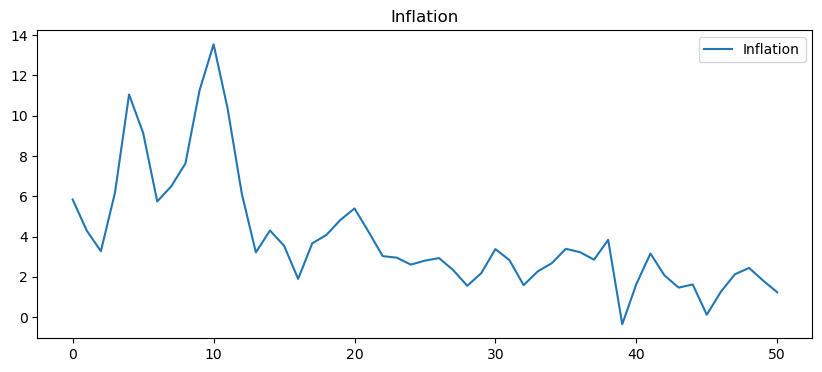

In [13]:
check_stationarity(df_usa['inflation'], 'Inflation')

ADF Statistic: -1.9169088063093929
p-value: 0.3241489594723447
The series is not stationary


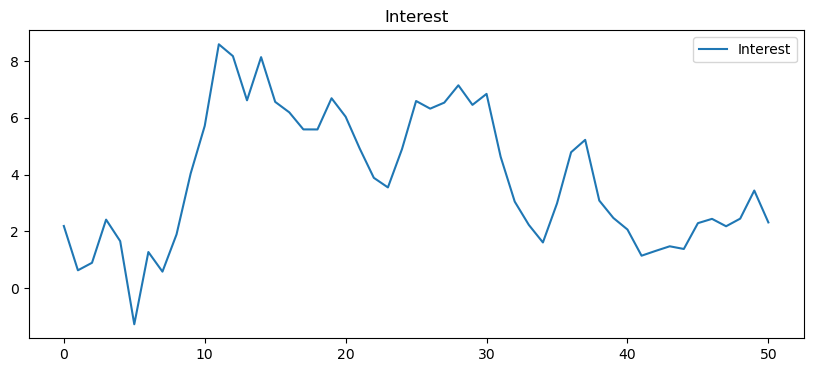

In [14]:
check_stationarity(df_usa['interest'], 'Interest')

In [15]:
df_usa.set_index('year', inplace=True)

df_usa['inflation_diff'] = df_usa['inflation'].diff()
df_usa['interest_diff'] = df_usa['interest'].diff()
df_usa.dropna(inplace=True)

df_usa.reset_index(inplace=True)


In [16]:
data_diff = df_usa[['year','inflation_diff', 'interest_diff']]

In [17]:
data_diff = data_diff.rename(columns = {'inflation_diff':'inflation',
                                  'interest_diff' : 'interest'})

ADF Statistic: -5.897235834601414
p-value: 2.832512243239068e-07
The series is stationary


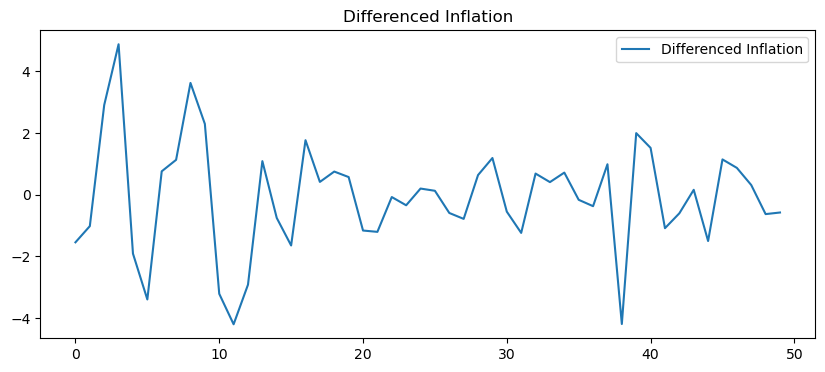

ADF Statistic: -4.013571904825847
p-value: 0.0013410885690285873
The series is stationary


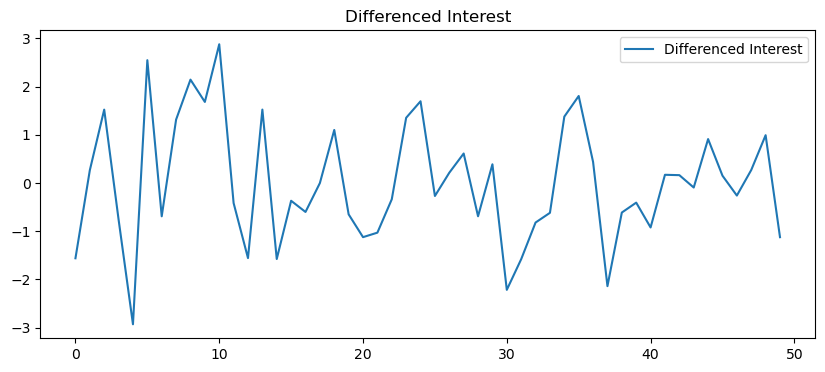

In [18]:
check_stationarity(data_diff['inflation'], 'Differenced Inflation')
check_stationarity(data_diff['interest'], 'Differenced Interest')


In [19]:
train_data = data_diff[:-10]
test_data = data_diff[-10:]


In [20]:
train_data.set_index('year', inplace=True)
test_data.set_index('year', inplace=True)

In [21]:
model = VAR(train_data)
var_model = model.fit(ic = 'aic')

/Users/onurberkeyesil/Documents/Tensorflow/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
print(f'Optimal Lag: {var_model.k_ar}')
var_model.summary()

Optimal Lag: 10


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Dec, 2023
Time:                     01:30:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.87386
Nobs:                     30.0000    HQIC:                   1.53974
Log likelihood:          -56.8190    FPE:                    4.86168
AIC:                     0.912182    Det(Omega_mle):         1.68224
--------------------------------------------------------------------
Results for equation inflation
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.752665         0.298260           -2.524           0.012
L1.inflation         -0.452265         0.287400           -1.574           0.116
L1.interest           0.265463         0.267577         

In [24]:
forecast_length = 10
y_pred = var_model.forecast(train_data.values[-var_model.k_ar:], steps = forecast_length)

y_pred_df = pd.DataFrame(y_pred, index=range(df_usa['year'].iloc[-1] + 1, df_usa['year'].iloc[-1] + 1 + forecast_length), columns=train_data.columns)

partial_orginal_data = df_usa[['inflation','interest']]
original_last_values = partial_orginal_data.iloc[-1]

forecasted_df_cumulative = y_pred_df.cumsum() + original_last_values
forecasted_df_cumulative


,inflation,interest
2021,4.738013,1.559860
2022,2.154604,4.876625
2023,2.276743,2.943073
2024,2.493326,3.362678
2025,0.056755,5.409603
2026,-0.442585,2.406289
2027,0.572272,3.240685
2028,0.657438,4.263910
2029,0.458462,1.518128
2030,1.243807,3.638464


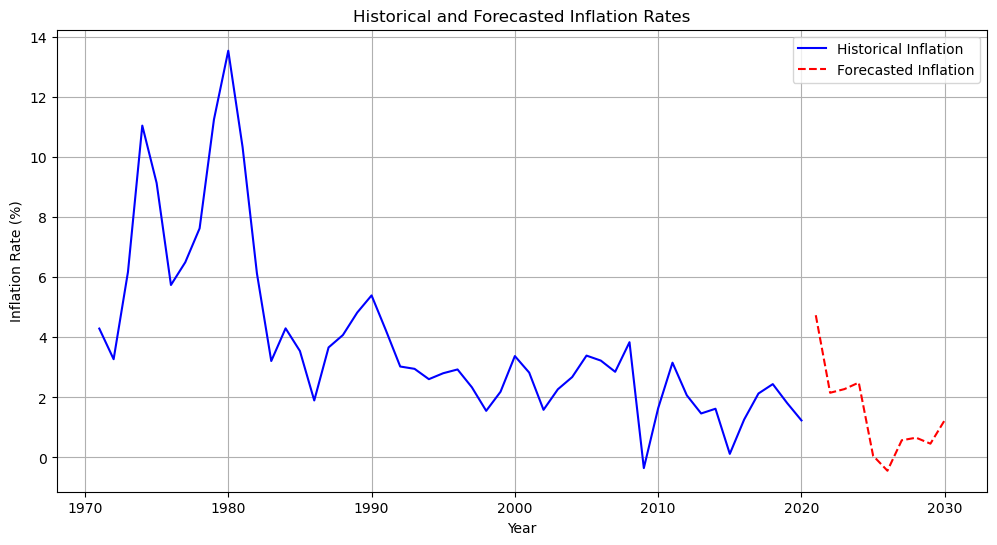

In [26]:
# Plotting the historical and forecasted data
plt.figure(figsize=(12, 6))

# Plotting historical data
plt.plot(df_usa['year'], df_usa['inflation'], label='Historical Inflation', color='blue')

# Plotting forecasted data
plt.plot(forecasted_df_cumulative.index, forecasted_df_cumulative['inflation'], label='Forecasted Inflation', color='red', linestyle='dashed')

plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.title('Historical and Forecasted Inflation Rates')
plt.legend()
plt.grid(True)
plt.show()



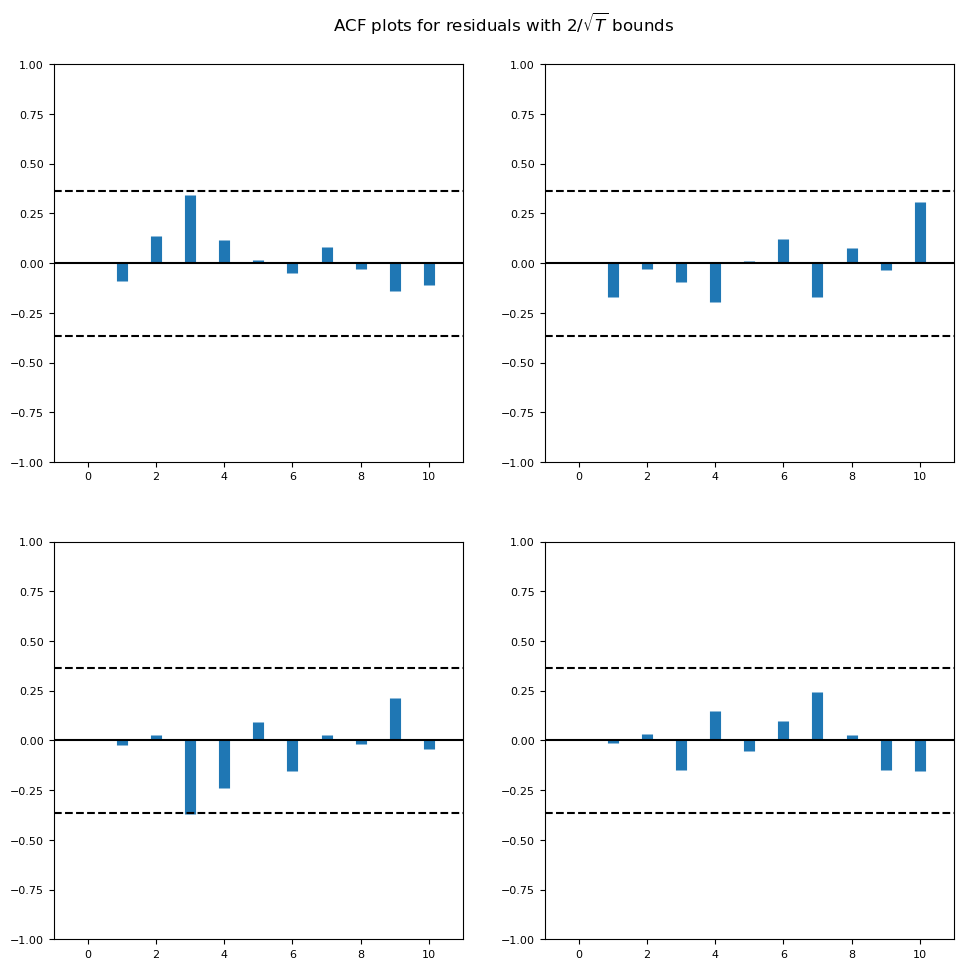

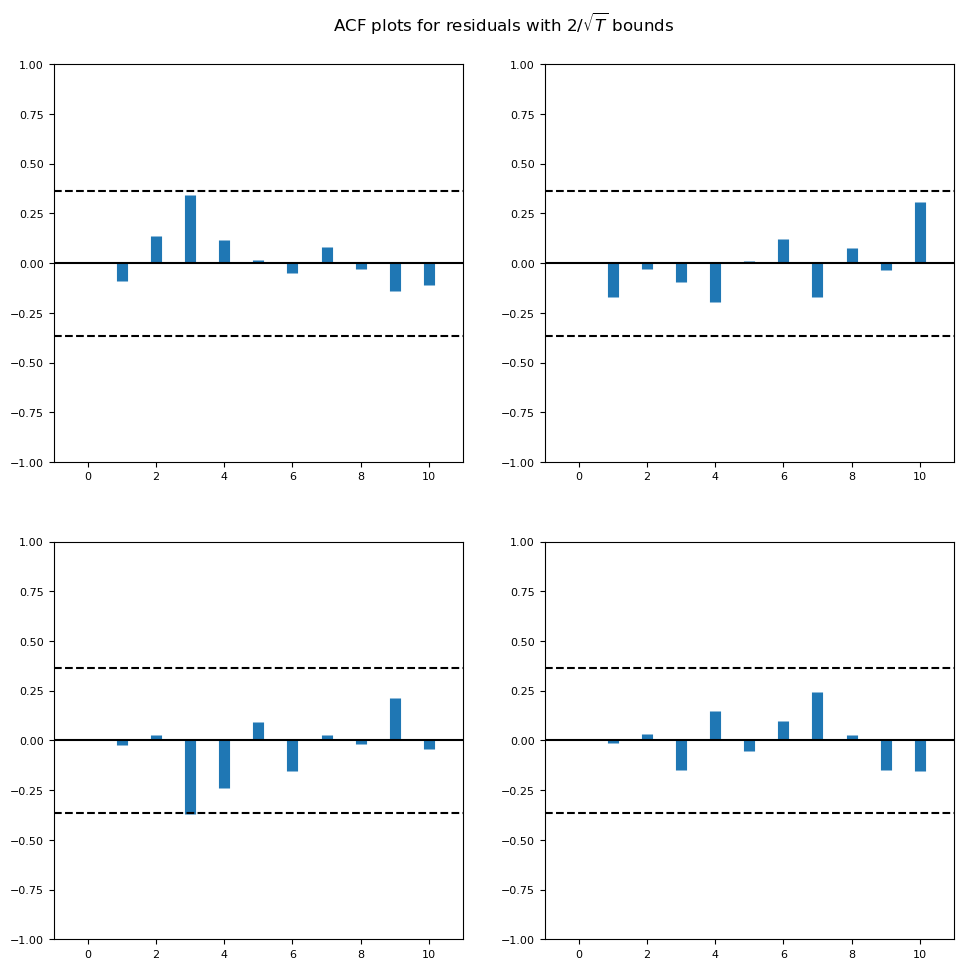

In [27]:
var_model.plot_acorr()

In [28]:
irf = var_model.irf(10)

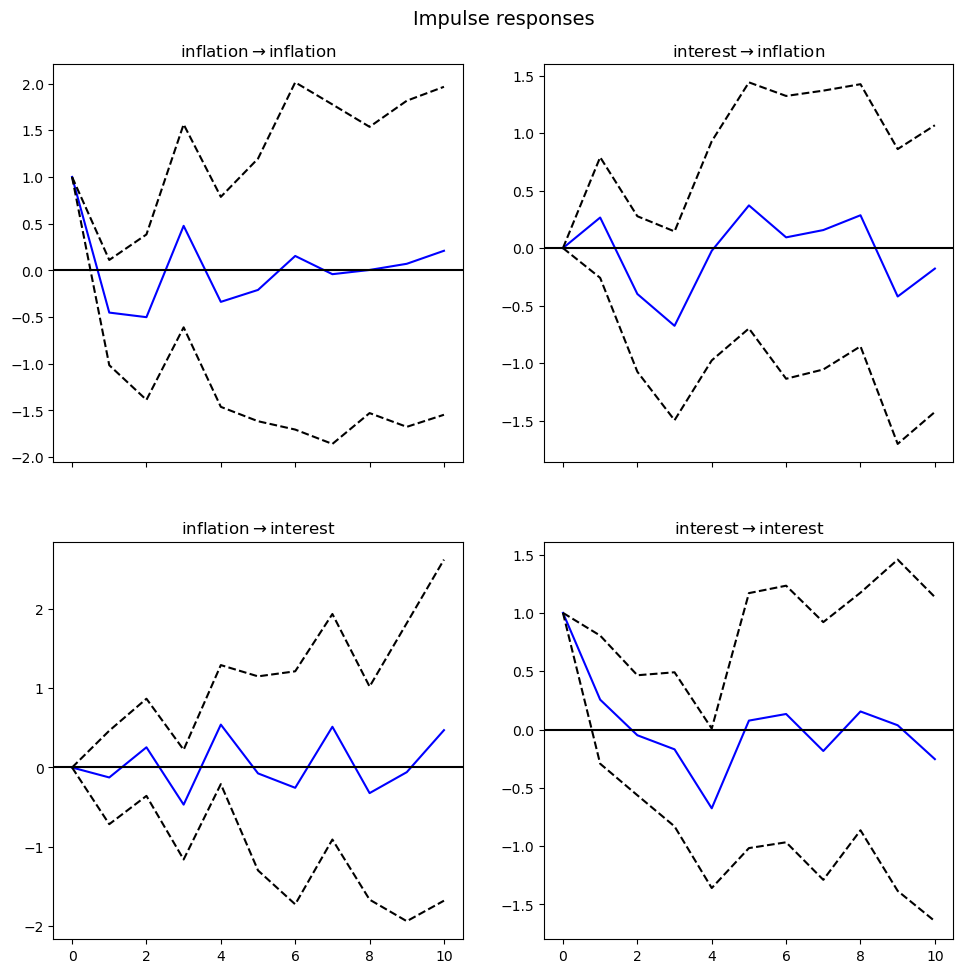

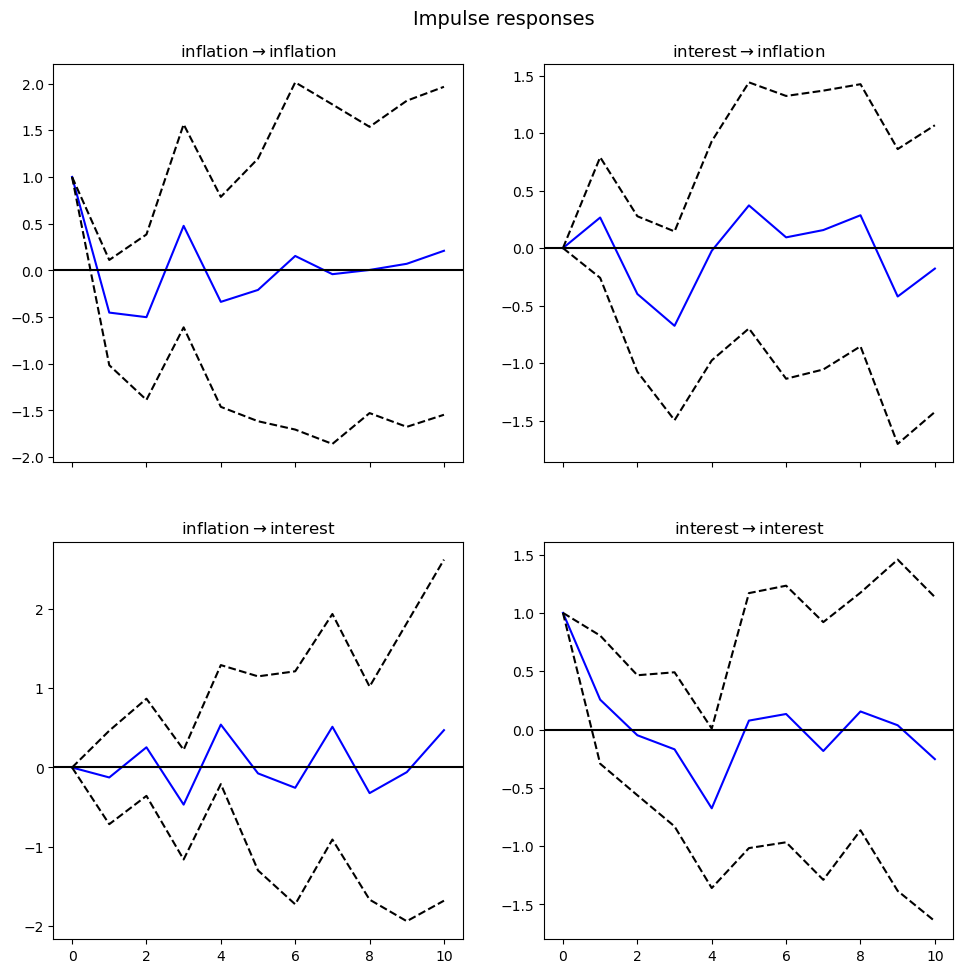

In [29]:
irf.plot(orth=False)

In [30]:
fevd = var_model.fevd(10)

In [31]:
fevd.summary()

FEVD for inflation
     inflation  interest
0     1.000000  0.000000
1     0.961140  0.038860
2     0.889053  0.110947
3     0.801912  0.198088
4     0.809172  0.190828
5     0.791857  0.208143
6     0.790827  0.209173
7     0.787127  0.212873
8     0.773271  0.226729
9     0.748545  0.251455

FEVD for interest
     inflation  interest
0     0.287810  0.712190
1     0.318124  0.681876
2     0.359455  0.640545
3     0.414886  0.585114
4     0.545408  0.454592
5     0.546813  0.453187
6     0.561797  0.438203
7     0.609098  0.390902
8     0.625065  0.374935
9     0.625566  0.374434




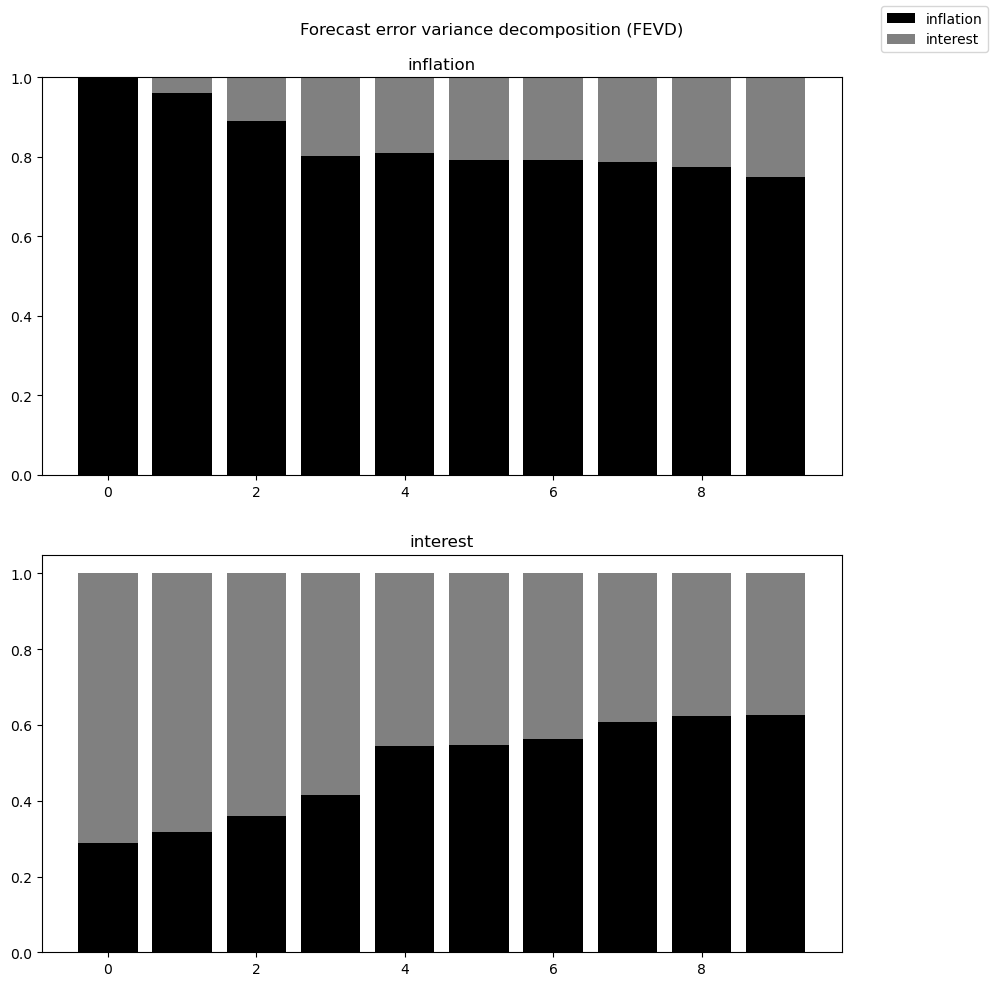

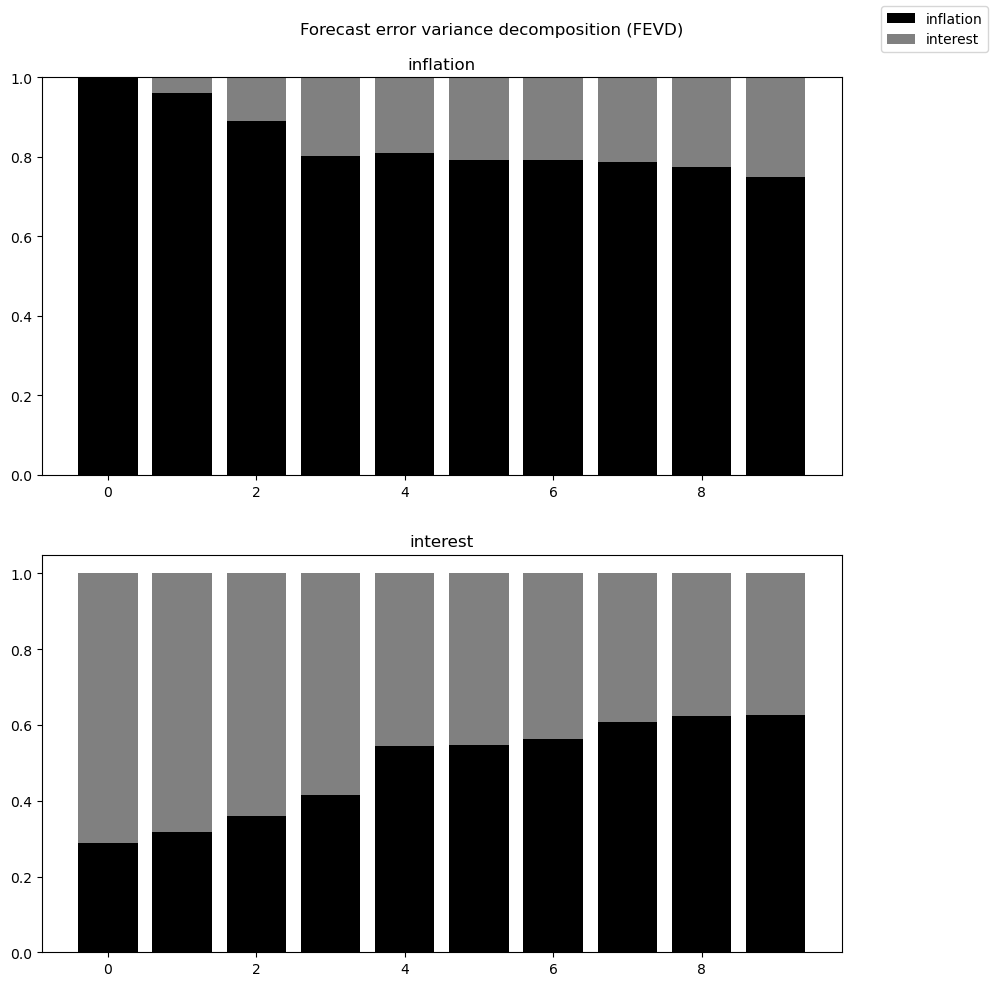

In [32]:
var_model.fevd(10).plot()

In [33]:
var_model.test_causality('inflation', ['interest'], kind='f').summary()

Test statistic,Critical value,p-value,df
1.688,2.412,0.160,"(10, 18)"
